In [9]:
import json
import gensim
import nltk
import string
import scipy
from nltk.corpus import stopwords
import numpy as np
import matplotlib.pyplot as plt
#from tqdm import tqdm

# Part II. Word Embedding

After we fetched all the alumni data from Wikipedia, what we need to do this part is to transform the alumni's bio texts into high dimentional vectors so that we can do further clustering and Similarity comparison based on it.

## Tokenization
We will first tokenize the texts and remove all the stop words from it, using the nltk library.

In [3]:
# Load alumni data and discipline data from json file
data = json.load(open('data.json'))
discipline = json.load(open('disciplines.json'))
del(discipline['Space sciences'])

In [7]:
def tokenization(text):
    """
    This function takes a a string of text. Then tokenize it as well as remove the stop words.
    
    Args:
        text: a text string
    Returns:
        a list of tokens(words)
    """
    stpwords = stopwords.words('english')
    text = text.lower()
    proc = ''
    i = 0
    while i < len(text):
        c = text[i]
        #remove punctuation
        if c not in string.punctuation:
            proc+=c
        elif c == "'":
            if i == (len(text)-1):
                break
            if text[i+1] == 's' and (i+2) == len(text):
                break
            if text[i+1] == 's' and text[i+2] == ' ':
                i+=1
        else:
            proc+=' '
        i+=1  
    #tokenization by nltk
    tokens = nltk.word_tokenize(proc)
    #remove stop words in tokens
    result = []
    for word in tokens:
        if word not in stpwords:
            result.append(word)
    return result

In [5]:
# Tokenize all alumni data
tokenized_data = {}
for school in data.keys():
    tokenized_data[school] = {}
    for person in data[school].keys():
        tokenized_data[school][person] = tokenization(data[school][person])

In [6]:
with open('tokenized_data.json', 'w') as fp:
    json.dump(tokenized_data, fp)

##  Doc2vec 

Now we need to get the vector of the texts by add up all word vectors from the text.  We will get the vector for each token with [**word2vec**](https://code.google.com/archive/p/word2vec/) using the [**pre-train model**](https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit) provided by google.

In [7]:
#load google word2vec model
model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

In [8]:
def embedding(tokens, model):
    """
    This function takes a list of tokens(words), and a pretrained word2vec model in gensim.
        Then transform the tokens into a single vector.
    Args: 
        tokens: a list of string representing the tokens
        model: a pretrained word2vec gensim model
    returns:
        vec: a np array representing the tokens.
    """
    vec = None
    for word in tokens:
        #if the model does not contain the word. just skip it
        if word not in model.vocab:
            continue
        if type(vec) != type(None):
            vec = vec + model[word]
        else:
            vec = model[word]
    return vec

In [9]:
processed_data = {}
for school in tokenized_data.keys():
    processed_data[school] = {}
    for person in data[school].keys():
        processed_data[school][person] = embedding(tokenized_data[school][person],model)

In [10]:
np.savez('vec_data.npz', **processed_data)

In [31]:
data_vec = np.load('vec_data.npz')


In [11]:
data_vec = processed_data

## Handle Disciplines

we will do the same techniques as the alumni data to all the discipline data to get the vector of each disciplines.


In [13]:
tokenized_discipline = {}
discipline_vec = {}
for academic in discipline.keys():
    #tokenize 
    tokenized_discipline[academic] = []
    for text in discipline[academic]:
      tokenized_discipline[academic].extend(tokenization(text))
    #doc2vec
    discipline_vec[academic] = embedding(tokenized_discipline[academic],model)
    

In [14]:
np.savez('vec_discipline.npz', **discipline_vec)
with open('tokenized_discipline.json', 'w') as fp:
    json.dump(tokenized_discipline, fp)

# Part III. Cosine Similarity

In this part we will use the cosine similarity to get the strength score for each alumni in each adademic fields. A alumni will have a higher score in an academic field if his data vector has a higher cosine similarity with the vector of the academic.

Then we will collect all scores from the alumni from a university and use the mean value as the score for the university.

## Scores: py dict

```
{ <school name1>: {
            <academic>: [[score1, score2, score3, ....],
                     [(name1,score1), (name2,score2), ...]]
              ...
            }
   ...
 }
```

In [15]:
#calculate scores for each alumni
scores = {}
for school in data_vec.keys():
    scores[school] = {}
    for academic in discipline_vec.keys():
        scores[school][academic] = [[],[]]
        displi = discipline_vec[academic]
        for name in data_vec[school].keys():
            alumni = data_vec[school][name]
            scores[school][academic][0].append(1- scipy.spatial.distance.cosine(alumni,displi))
            scores[school][academic][1].append((1- scipy.spatial.distance.cosine(alumni,displi),name))


In [16]:
with open('similarity_score.json', 'w') as fp:
    json.dump(scores, fp)

In [17]:
#get the score for each university
final_scores = {}
for school in scores.keys():
    final_scores[school] = {}
    for academic in scores[school].keys():
        final_scores[school][academic] = np.mean(scores[school][academic][0])
     

In [18]:
#construct the dictionary for plotting
plot_dict = {}
for school in final_scores.keys():
    for academic in final_scores[school].keys():
        if academic not in plot_dict.keys():
            plot_dict[academic] = [[],[]]
        plot_dict[academic][0].append(school)
        plot_dict[academic][1].append(final_scores[school][academic])

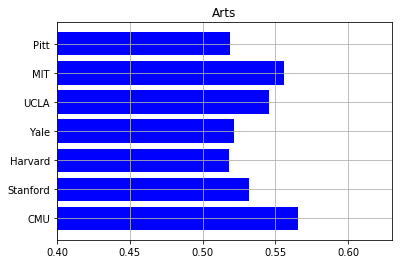

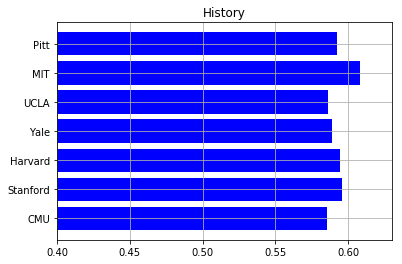

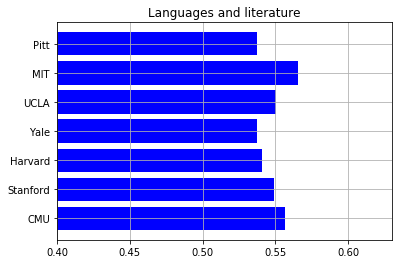

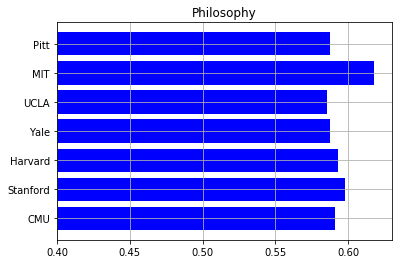

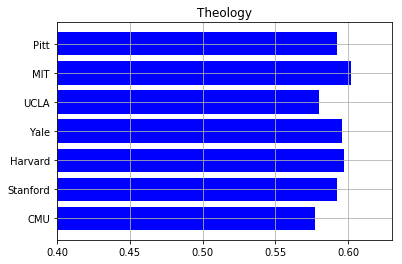

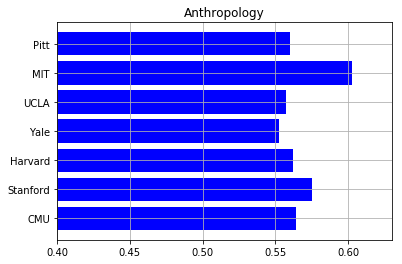

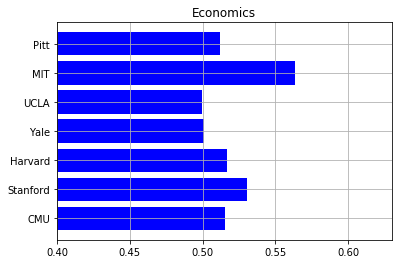

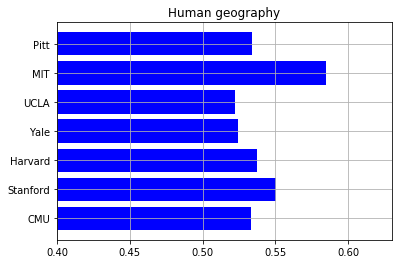

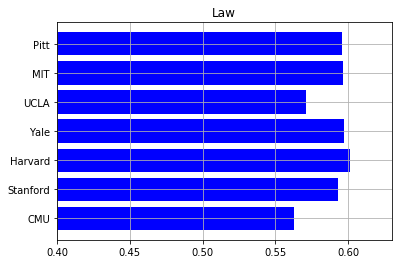

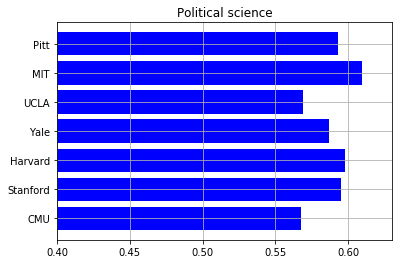

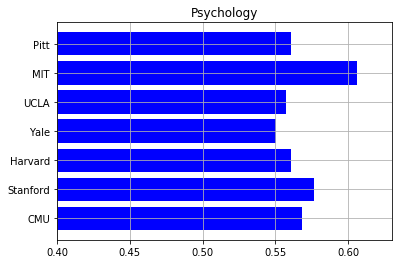

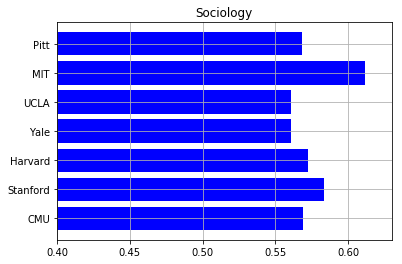

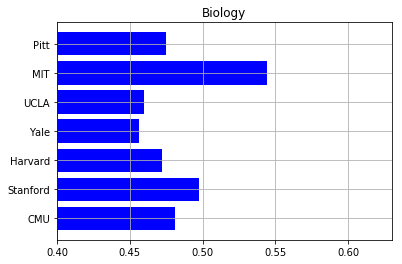

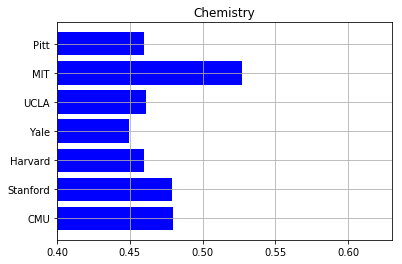

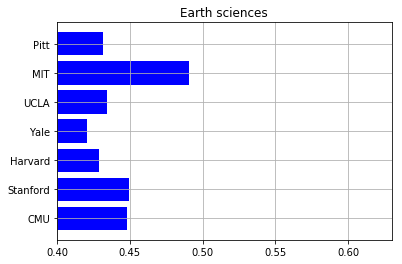

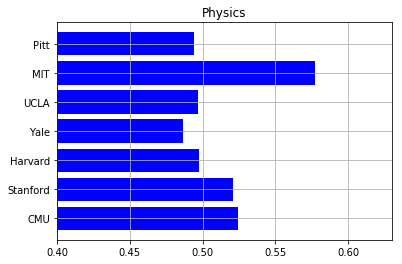

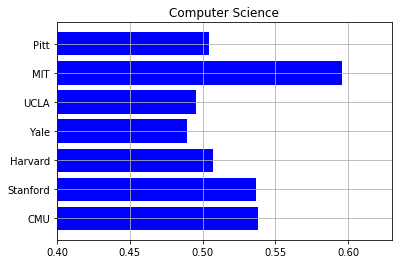

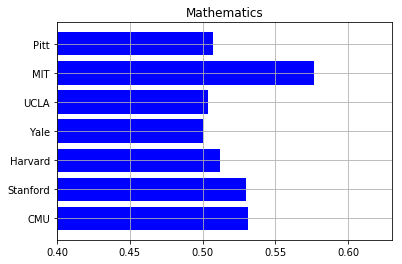

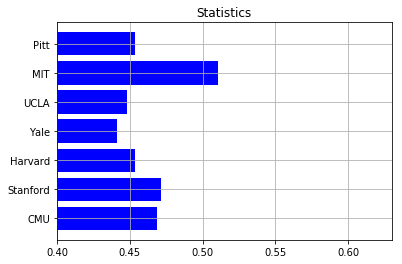

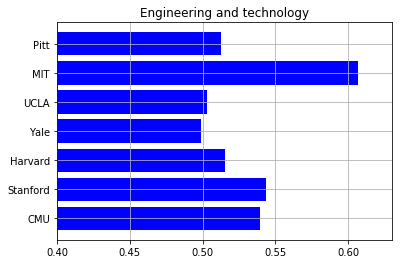

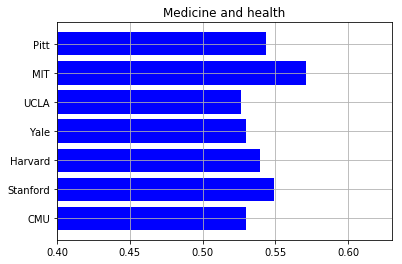

In [21]:
#plot the graphs
for key in plot_dict.keys(): 
    x = plot_dict[key][0]
    y = plot_dict[key][1]
    plt.barh(range(len(x)), y, color = 'b')
    plt.yticks(range(len(x)),x)
    plt.title(key)
    plt.xlim(0.4, 0.63)
    plt.grid()
    plt.show()

In [29]:

for academic in scores['CMU'].keys():
    print(academic)
    scores['CMU'][academic][1].sort(reverse=True)
   
    for i in range(5):
        print(scores['CMU'][academic][1][i])

Arts
(0.8978172540664673, 'Golan_Levin')
(0.8845943212509155, 'Joyce_Kozloff')
(0.8836503624916077, 'Richard_Rappaport')
(0.8698902726173401, 'Philip_Pearlstein')
(0.8555537462234497, 'Mel_Bochner')
History
(0.8993697762489319, 'Harrison_White')
(0.8885684609413147, 'Herbert_A._Simon')
(0.8780751824378967, 'Jeffrey_Pfeffer')
(0.870668351650238, 'Brian_MacWhinney')
(0.8635125756263733, 'Walter_Dill_Scott')
Languages and literature
(0.9012560844421387, 'Brian_MacWhinney')
(0.8689244985580444, 'Herbert_A._Simon')
(0.8423580527305603, 'Harrison_White')
(0.8409110307693481, 'Walter_Dill_Scott')
(0.8381473422050476, 'George_Loewenstein')
Philosophy
(0.9062706828117371, 'Herbert_A._Simon')
(0.8966803550720215, 'Harrison_White')
(0.8813345432281494, 'Dana_Scott')
(0.8813345432281494, 'Dana_S._Scott')
(0.877239465713501, 'George_Loewenstein')
Theology
(0.8613532185554504, 'Harrison_White')
(0.8521102070808411, 'Herbert_A._Simon')
(0.8411178588867188, 'John_Forbes_Nash')
(0.8402970433235168, 'Je

In [3]:
test = 'Andrew Carnegie was a Scottish-American industrialist, business magnate, and philanthropist. Carnegie led the expansion of the American steel industry in the late 19th century and is often identified as one of the richest people.'

In [4]:
print(test)

Andrew Carnegie was a Scottish-American industrialist, business magnate, and philanthropist. Carnegie led the expansion of the American steel industry in the late 19th century and is often identified as one of the richest people.


In [11]:
test=tokenization(test)